# Mode Diagnostics: Wait + Travel

Unified exploratory notebook covering wait-time and travel-time fits. All heavy lifting lives in `src/modeling` helpers, so this document just orchestrates the dashboards and reference snapshots.

In [1]:
import sys
from pathlib import Path

import ipywidgets as widgets
from IPython.display import display

In [2]:
# Add src/ to path for project helpers
root = Path.cwd().resolve()
for candidate in [root, *root.parents]:
    src_dir = candidate / "src"
    if src_dir.exists():
        sys.path.append(str(src_dir))
        break

from modeling.wait_dashboard import (
    WaitDashboard,
    load_bike_dataset,
    load_taxi_dataset,
    render_wait_snapshot,
)
from modeling.travel_diagnostics import load_travel_diagnostics

In [3]:
# Downsample large raw datasets to keep memory usage manageable.
WAIT_TAXI_MAX_ROWS = 500_000
WAIT_BIKE_MAX_ROWS = 500_000
TRAVEL_TAXI_MAX_ROWS = 500_000
TRAVEL_BIKE_MAX_ROWS = 500_000

In [4]:
# Load datasets for both components
wait_taxi = load_taxi_dataset(max_rows=WAIT_TAXI_MAX_ROWS)
wait_bike = load_bike_dataset(max_rows=WAIT_BIKE_MAX_ROWS)
travel_diag = load_travel_diagnostics(
    taxi_max_rows=TRAVEL_TAXI_MAX_ROWS,
    bike_max_rows=TRAVEL_BIKE_MAX_ROWS,
)

Loading 6 taxi files...
  Reading yellow_tripdata_2024-01.parquet...
  Reading yellow_tripdata_2024-02.parquet...
  Reading yellow_tripdata_2024-03.parquet...
  Reading yellow_tripdata_2024-04.parquet...
  Reading yellow_tripdata_2024-05.parquet...
  Reading yellow_tripdata_2024-06.parquet...
Loaded 2,989,508 taxi trips across 57 active zones (Jan-Jun 2024)
Loaded 18,296,123 bike trips across 692 active stations
[taxi] Loading yellow_tripdata_2024-01.parquet ...
[taxi] Loading yellow_tripdata_2024-02.parquet ...
[taxi] Loading yellow_tripdata_2024-03.parquet ...
[taxi] Loading yellow_tripdata_2024-04.parquet ...
[taxi] Loading yellow_tripdata_2024-05.parquet ...
[taxi] Loading yellow_tripdata_2024-06.parquet ...
Loading Citi Bike trips ...


/Users/atharvramesh/UCSD/Fall2025/ECE225A/NYC_Public_Transit/src/modeling/travel_diagnostics.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["mode", "distance_bin", "is_rush", "is_weekend"])["travel_min"]


## Wait-time dashboards

In [5]:
taxi_dashboard = WaitDashboard(wait_taxi, "🚕 Taxi Dashboard")
bike_dashboard = WaitDashboard(wait_bike, "🚲 Bike Dashboard")

tabs = widgets.Tab(children=[taxi_dashboard.widget, bike_dashboard.widget])
tabs.set_title(0, "Taxi")
tabs.set_title(1, "Citi Bike")
display(tabs)

### Wait-time snapshots

Selection too sparse (mean=0.55, nonzero=0.41).

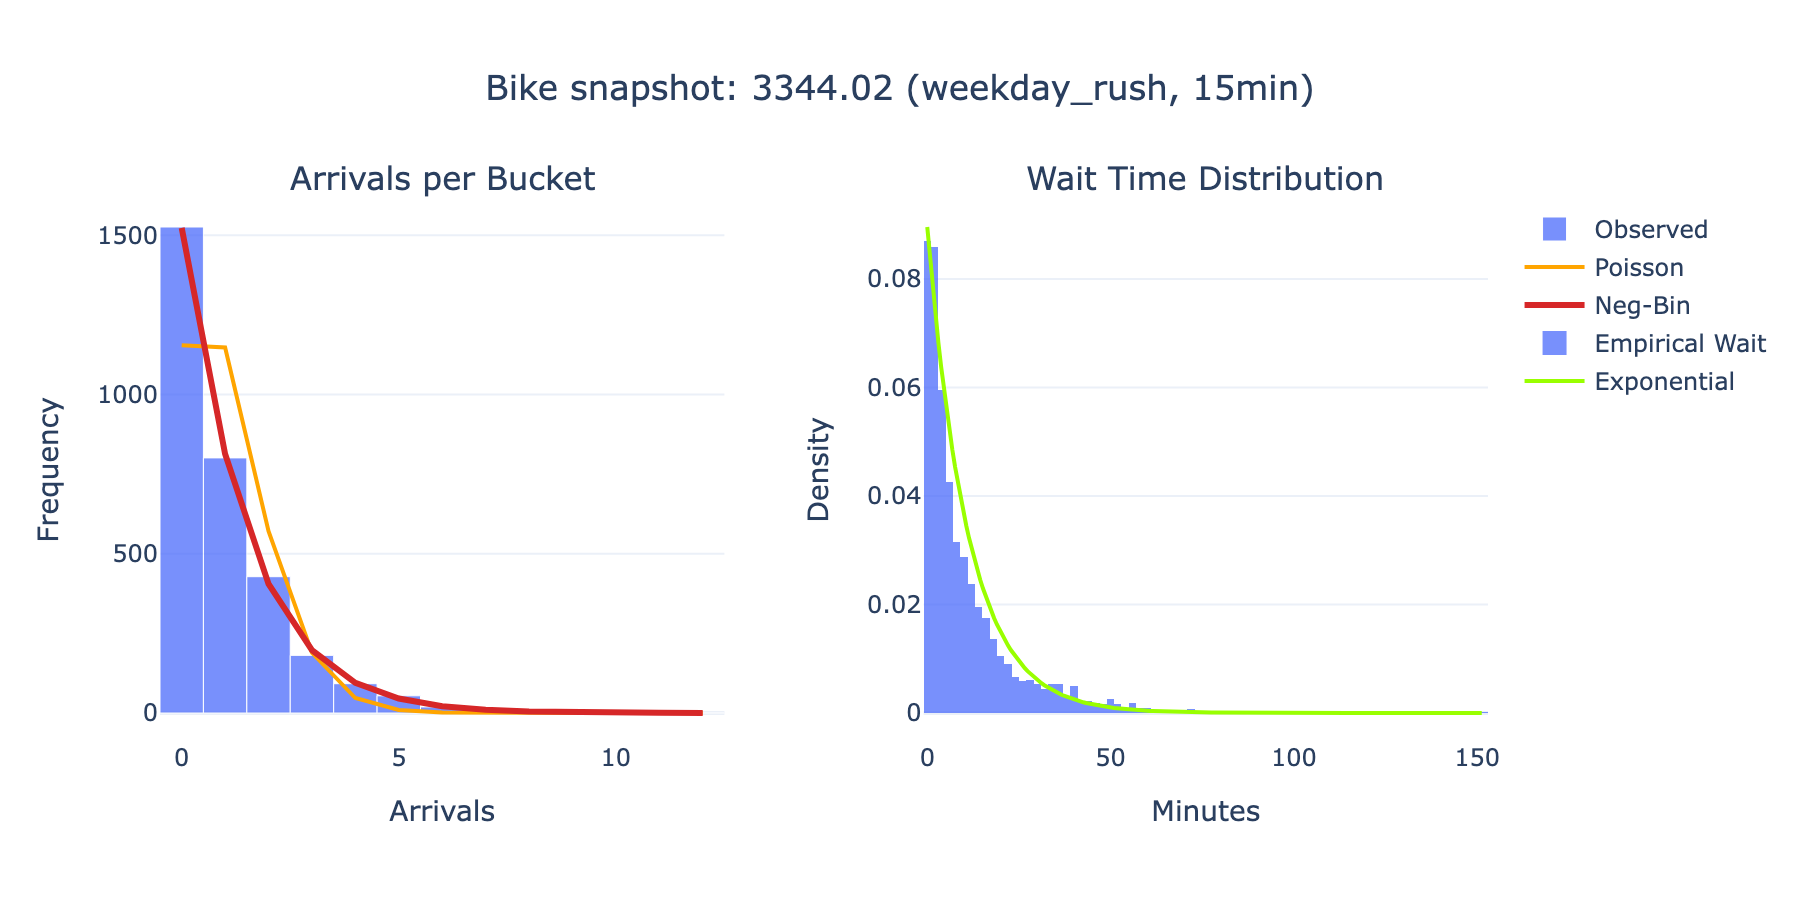

In [6]:
if wait_taxi.locations:
    render_wait_snapshot(
        wait_taxi,
        wait_taxi.locations[0],
        cohort="weekday_rush",
        title_prefix="Taxi snapshot",
    )

if wait_bike.locations:
    render_wait_snapshot(
        wait_bike,
        wait_bike.locations[0],
        cohort="weekday_rush",
        title_prefix="Bike snapshot",
    )

## Travel-time summaries

In [7]:
display(travel_diag.bin_stats_summary().head(12))
display(travel_diag.low_sample_bins())
display(travel_diag.gamma_coverage())
display(travel_diag.sample_counts_table().head(20))

,mode,distance_bin,cohorts,min_samples,median_samples,max_samples
0,bike,0-2km,4,856510,2820983.5,4715497
2,bike,2-4km,4,372897,1188399.5,1758538
3,bike,4-6km,4,120852,373335.5,521217
4,bike,6-8km,4,39506,122710.5,172994
5,bike,8-10km,4,12768,40157.0,58142
1,bike,10-12km,4,4136,12370.5,18852
6,taxi,0-2km,4,71078,226435.0,468649
8,taxi,2-4km,4,68535,220164.0,450356
9,taxi,4-6km,4,26033,80511.5,171348
10,taxi,6-8km,4,10473,32581.0,70350


,mode,distance_bin,is_rush,is_weekend,sample_count,meets_gamma
47,taxi,10-12km,True,True,3415,True
23,bike,10-12km,True,True,4136,True
43,taxi,8-10km,True,True,5508,True
21,bike,10-12km,False,True,9983,True
39,taxi,6-8km,True,True,10473,True
46,taxi,10-12km,True,False,11069,True
45,taxi,10-12km,False,True,11176,True
19,bike,8-10km,True,True,12768,True
22,bike,10-12km,True,False,14758,True
42,taxi,8-10km,True,False,16975,True


,fraction_gamma_ready
mode,
bike,1.0
taxi,1.0


,mode,distance_bin,rush_label,weekend_label,sample_count,meets_gamma
0,bike,0-2km,Off-peak,Weekday,4715497,True
1,bike,0-2km,Off-peak,Weekend,1946639,True
2,bike,0-2km,Rush,Weekday,3695328,True
3,bike,0-2km,Rush,Weekend,856510,True
4,bike,2-4km,Off-peak,Weekday,1758538,True
5,bike,2-4km,Off-peak,Weekend,860943,True
6,bike,2-4km,Rush,Weekday,1515856,True
7,bike,2-4km,Rush,Weekend,372897,True
8,bike,4-6km,Off-peak,Weekday,521217,True
9,bike,4-6km,Off-peak,Weekend,279865,True


### Gamma diagnostics

In [8]:
gamma_dashboard = travel_diag.build_gamma_dashboard()
display(gamma_dashboard)

### Gamma snapshot

**Gamma overlay — Bike, 0-2km, Off-peak, Weekday**

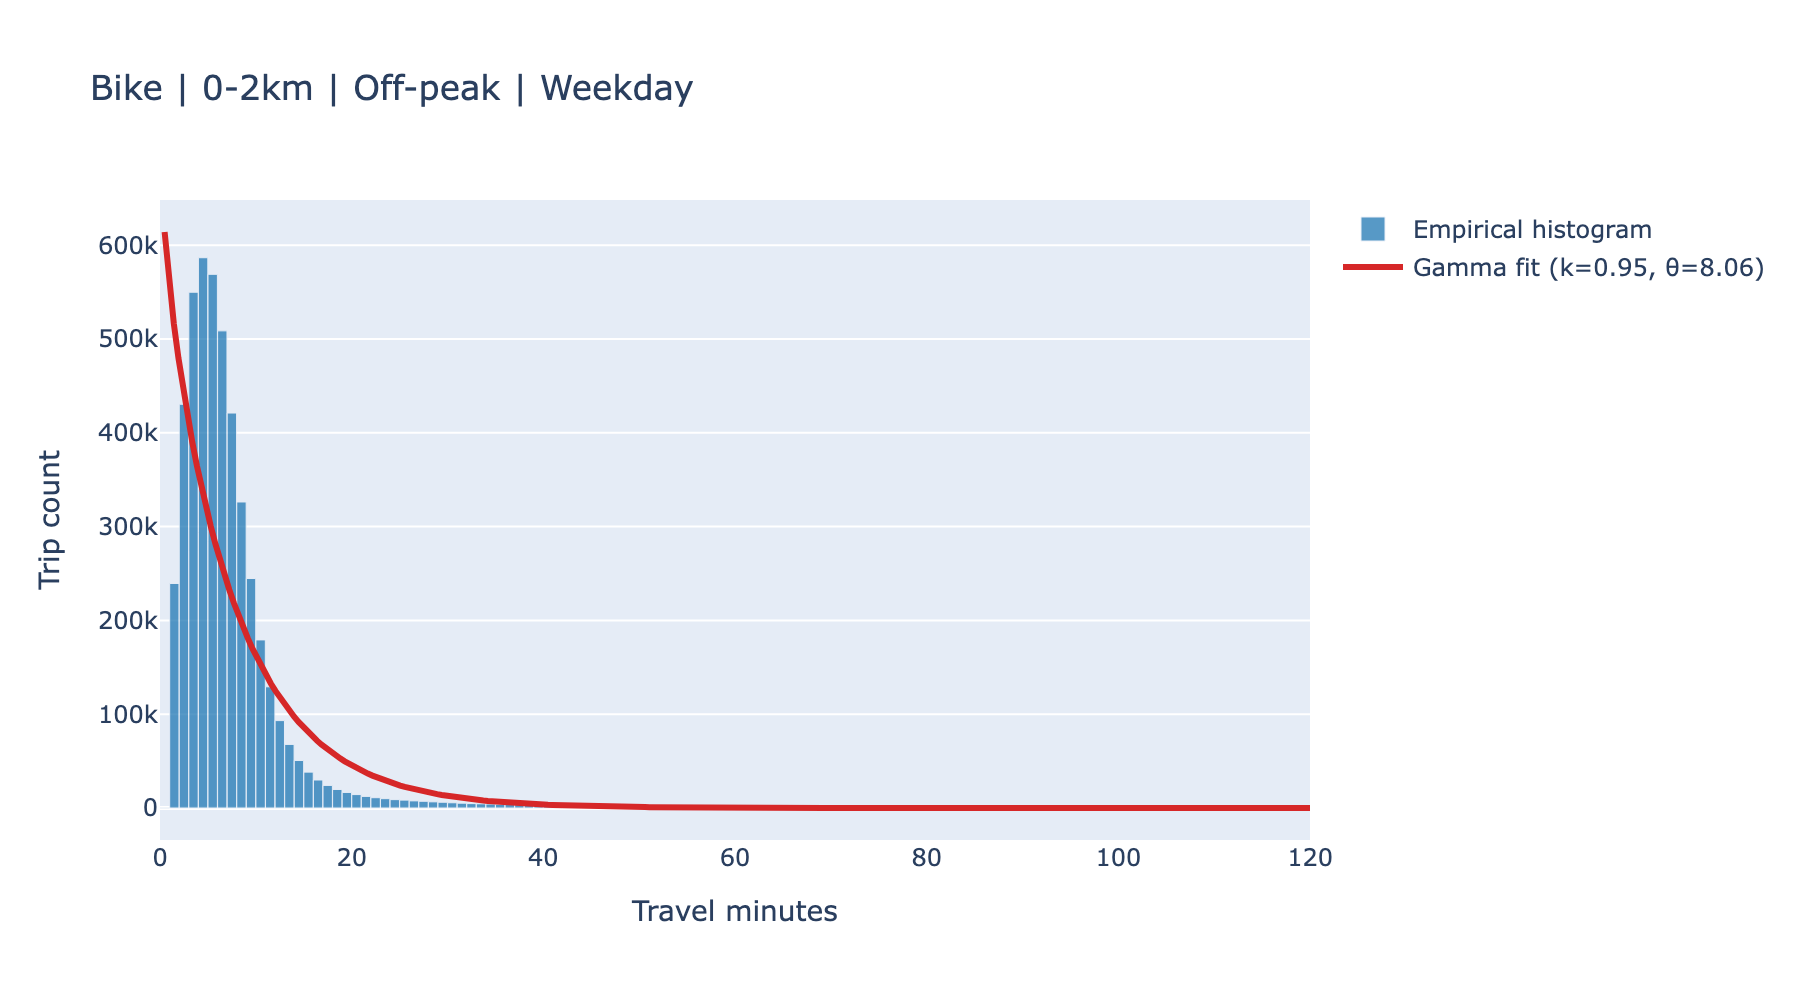

sample_count    4.715497e+06
mean_minutes    7.664186e+00
var_minutes     6.178216e+01
gamma_k         9.507560e-01
gamma_theta     8.061150e+00
overall_mean    7.664186e+00
overall_var     6.178216e+01
Name: metrics, dtype: float64

In [9]:
travel_diag.render_gamma_snapshot(
    mode="bike",
    distance_bin=travel_diag.distance_levels[0] if travel_diag.distance_levels else None,
    is_rush=False,
    is_weekend=False,
    title_prefix="Gamma overlay",
)

### Lognormal overlays

In [10]:
lognorm_dashboard = travel_diag.build_lognormal_overlay_dashboard()
display(lognorm_dashboard)

### Lognormal snapshot

**Gamma vs lognormal — Bike, 0-2km, Off-peak, Weekday**

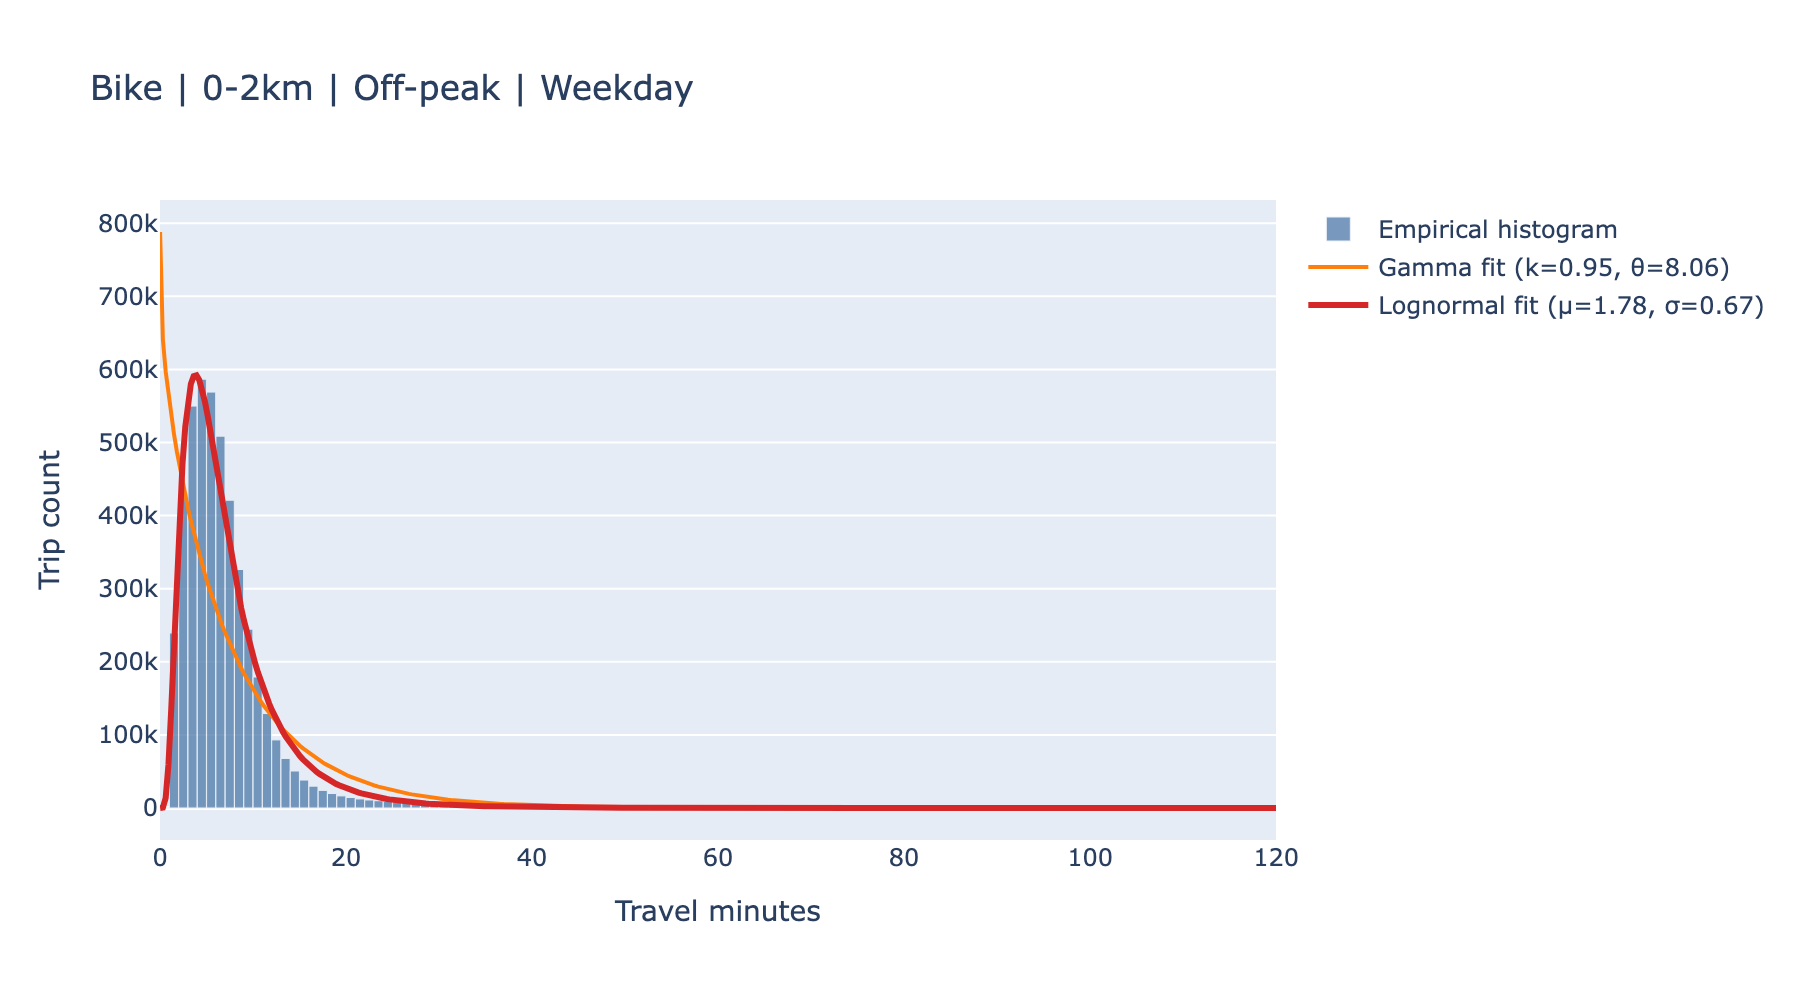

mu_log           1.782367
sigma_log        0.667459
samples           4715497
gamma_samples     4715497
gamma_mean       7.664186
bike_type             all
Name: distribution_params, dtype: object

In [11]:
travel_diag.render_lognormal_snapshot(
    mode="bike",
    distance_bin=travel_diag.distance_levels[0] if travel_diag.distance_levels else None,
    is_rush=False,
    is_weekend=False,
    title_prefix="Gamma vs lognormal",
)

### Lognormal GLM summary

In [12]:
display(travel_diag.lognormal_summary())
display(travel_diag.lognormal_coeff_table())

,mode,samples,sigma_log,r_squared_log,mae_log
0,bike,17767822,0.485551,0.620739,0.331522
1,taxi,2592115,0.394214,0.614445,0.303776


,const,distance_km,distance_sq,is_rush,is_weekend,is_ebike,sigma_log
bike,1.219927,0.700562,-0.048917,-0.024851,0.080579,-0.19289,0.485551
taxi,1.255032,0.508956,-0.031902,0.055543,-0.088005,0.00000,0.394214


### Lognormal GLM diagnostics

In [13]:
log_glm_dashboard = travel_diag.build_lognormal_diag_dashboard()
display(log_glm_dashboard)

### Log-likelihood and error metrics

In [14]:
ll_summary, per_trip, overall_delta, comparable = travel_diag.log_likelihood_tables()
display(ll_summary)
display(per_trip)
print(f"Overall Δ log-likelihood (lognormal - gamma): {overall_delta:,.2f} across {comparable:,} comparable trips")

display(travel_diag.error_metrics_table())

,gamma_loglike,lognormal_loglike,delta
mode,,,
bike,-5.644643e+07,-5.126203e+07,5.184395e+06
taxi,-7.605496e+06,-7.399036e+06,2.064596e+05


,gamma_mean,lognormal_mean
mode,,
bike,-3.176891,-2.885105
taxi,-2.934089,-2.854440


Overall Δ log-likelihood (lognormal - gamma): 5,390,854.43 across 20,359,937 comparable trips


,mode,model,samples,mae_min,rmse_min
0,bike,lognormal_glm,17767822,4.398971,8.513747
1,bike,gamma_bin,17767822,4.805260,8.418706
2,taxi,lognormal_glm,2592115,3.825717,5.639232
3,taxi,gamma_bin,2592115,3.971541,5.639959
